In [1]:
#%matplotlib notebook
import time, winsound, h5py
import numpy as np
import matplotlib.pyplot as plt
from lcls_beamline_toolbox.xraybeamline2d import beam1d as beam, optics1d as optics, beamline1d as beamline

### Beam parameters

In [2]:
# number of sampling points
N = 2048
# photon energy in eV
E0 = 17795

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
    'photonEnergy': E0,
    'N': N,
    'sigma_x': 23e-6,
    'sigma_y': 23e-6,
    'rangeFactor': 5,
    'scaleFactor': 10,
    'z_source': 630
}

### Define beamline for loops

In [3]:
def define_devices(shapeError, focal_length, slit_width=500e-6,
                   f1 = 9.775183946488294, f2 = 10., alphaAsym=np.deg2rad(27.98), E0 = E0,
                   f0 = 290., d23=7.):
    # crystal reflection hkl index
    hkl = [6,6,0]

    # viewing point upstream of monochromator
    im0 = optics.PPM('im0', z=870, FOV=2e-3, N=256)
    crl0 = optics.CRL('crl0', z=920, E0=E0, f=f0, diameter=2e-3)

    # first crystal: symmetric reflection
    crystal1 = optics.Crystal('c1', hkl=hkl, length=10e-2, width=20e-3, z=930, E0=E0,
                              alphaAsym=0, orientation=0, pol='s', delta=0.e-6)

    # second crystal: asymmetric reflection, orientation flipped relative to crystal1
    crystal2 = optics.Crystal('c2', hkl=hkl, length=10e-2, width=20e-3, z=crystal1.z+.2, E0=E0,alphaAsym=alphaAsym, 
                              orientation=2,pol='s', delta=0e-6, shapeError = shapeError)
    # printing crystal incidence and reflection angles for confirmation
    print('crystal 2 incidence angle: {:.2f} degrees'.format(crystal2.alpha*180/np.pi))
    print('crystal 2 exit angle: {:.2f} degrees'.format(crystal2.beta0*180/np.pi))

    im_upstream = optics.PPM('im_upstream', z=crystal2.z + f1 - .1, FOV=2e-3, N=256)

    # CRL with ~1 meter focal length (modeled as single element for now)
    crl1 = optics.CRL('crl1', z=crystal2.z+f1, E0=E0, f=focal_length, diameter=5e-3)

    # viewing point downstream of first crl
    im1 = optics.PPM('im1', z=crl1.z+.1,N=256,FOV=2e-3)
    
    # slit at focus
    slit = optics.Slit('slit', z=crl1.z+f2, x_width=slit_width, y_width=2e-3)

    # viewing point at focus
    focus = optics.PPM('focus', z=crl1.z+f2 + 1e-3, FOV=100e-6, N=256)
    '''
    # slit at focus
    slit = optics.Slit('slit', z=crl1.z+f2 + 1e-3, x_width=slit_width, y_width=2e-3)

    # second CRL with ~1 meter focal length, for collimation
    crl2 = optics.CRL('crl2', z=crl1.z+2*f2, E0=E0, f=f2, diameter=5e-3)

    # third crystal, symmetric reflection, same orientation as crystal2
    crystal3 = optics.Crystal('c3', hkl=hkl, length=10e-2, width=10e-3, z=crl2.z+d23, E0=E0,alphaAsym=0, orientation=2,
                             asym_type='emergence',pol='s')

    # fourth crystal, asymmetric reflection, same orientation as crystal1
    crystal4 = optics.Crystal('c4', hkl=hkl, length=10e-2, width=10e-3, z=crl2.z+d23 + (f1-d23)*np.cos(crystal1.beta0*2), E0=E0,alphaAsym=-alphaAsym, 
                              asym_type='emergence', orientation=0,pol='s')

    # viewing point just downstream of monochromator
    im2 = optics.PPM('im2', z=crystal4.z+.1, FOV=2e-3, N=256)
    
    # list of devices to propagate through
    devices = [crl0,im0,crystal1,crystal2,im_upstream, im1, crl1, slit, focus, crl2, crystal3, crystal4, im2]
    '''
    devices = [crl0,im0,crystal1,crystal2,im_upstream, im1, crl1, slit, focus]
    
    return devices

In [4]:
from lcls_beamline_toolbox.xraybeamline2d.util import Util
def get_pulse(pulse, image_name, x_pos=0, y_pos=0, shift=None):
    minx = np.round(np.min(pulse.x[image_name]) * 1e6)
    maxx = np.round(np.max(pulse.x[image_name]) * 1e6)
    miny = np.round(np.min(pulse.y[image_name]) * 1e6)
    maxy = np.round(np.max(pulse.y[image_name]) * 1e6)

    # get number of pixels
    M = pulse.x[image_name].size
    N = pulse.y[image_name].size

    # calculate pixel sizes (microns)
    dx = (maxx - minx) / M
    dy = (maxy - miny) / N

    # calculate indices for the desired location
    x_index = int((x_pos - minx) / dx)
    y_index = int((y_pos - miny) / dy)

    # calculate temporal intensity
    y_data = np.abs(pulse.time_stacks[image_name][y_index, x_index, :]) ** 2
    
    shift = -pulse.t_axis[np.argmax(y_data)]
    
    if shift is not None:
        y_data = np.roll(y_data, int(shift/pulse.deltaT))

    # get gaussian stats
    centroid, sx = Util.gaussian_stats(pulse.t_axis, y_data)
    fwhm = int(sx * 2.355)

    # gaussian fit
    gauss_plot = Util.fit_gaussian(pulse.t_axis, centroid, sx)
        
    # [fs], normalized intensity [simulated], [Gaussian Fit]
    return pulse.t_axis, y_data/np.max(y_data), gauss_plot

def get_spectrum(pulse, image_name, x_pos=0, y_pos=0, integrated=False):
    minx = np.round(np.min(pulse.x[image_name]) * 1e6)
    maxx = np.round(np.max(pulse.x[image_name]) * 1e6)
    miny = np.round(np.min(pulse.y[image_name]) * 1e6)
    maxy = np.round(np.max(pulse.y[image_name]) * 1e6)

    # get number of pixels
    M = pulse.x[image_name].size
    N = pulse.y[image_name].size

    # calculate pixel sizes (microns)
    dx = (maxx - minx) / M
    dy = (maxy - miny) / N

    # calculate indices for the desired location
    x_index = int((x_pos - minx) / dx)
    y_index = int((y_pos - miny) / dy)

    # calculate spectral intensity
    if integrated:
        y_data = np.sum(np.abs(pulse.energy_stacks[image_name])**2, axis=(0,1))
    else:
        y_data = np.abs(pulse.energy_stacks[image_name][y_index,x_index,:])**2

    # get gaussian stats
    centroid, sx = Util.gaussian_stats(pulse.energy, y_data)
    fwhm = sx * 2.355

    # gaussian fit to plot
    gauss_plot = Util.fit_gaussian(pulse.energy, centroid, sx)

    # change label depending on bandwidth
    if fwhm >= 1:
        width_label = '%.1f eV FWHM' % fwhm
    elif fwhm > 1e-3:
        width_label = '%.1f meV FHWM' % (fwhm * 1e3)
    else:
        width_label = u'%.1f \u03BCeV FWHM' % (fwhm * 1e6)
    
    # [eV], normalized intensity [simulated], [Gaussian Fit]
    return pulse.energy - pulse.E0, y_data/np.max(y_data), gauss_plot


In [5]:
%%capture capt
tstart = time.time()
# initialize optical elements
f1 = 9.775183946488294
f2 = 10.

''' define device '''
devices = define_devices(np.zeros(500), f2)

# initialize beamline
mono_beamline = beamline.Beamline(devices)

for oe in devices:
    if oe.name == 'c1':
        print('crystal 1 incidence angle: {:.2f} degrees'.format(oe.alpha*180/np.pi))
        print('crystal 1 exit angle: {:.2f} degrees\n\n\n'.format(oe.beta0*180/np.pi))

# propagate
beam_params['photonEnergy'] = E0
pulse = beam.Pulse(beam_params=beam_params, tau=100, time_window=10000)
pulse.propagate(beamline=mono_beamline, screen_names=['im0','focus'])
tfin = time.time()


In [6]:
print('each run: {}s, per slice: {}ms'.format(round(tfin-tstart,2), round(1000*(tfin-tstart)/pulse.N,2)))
t_axis, t_pulse, t_pulse_fit = get_pulse(pulse, 'focus')
energy_axis, spectrum, spectrum_fit = get_spectrum(pulse,'focus',integrated=True)

each run: 15.2s, per slice: 67.86ms


Text(0, 0.5, 'shapeError (nm)')

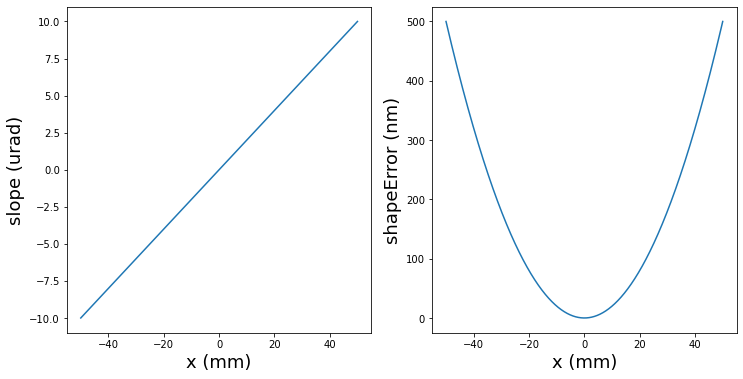

In [7]:
''' crystal shape error demonstration '''
mirror_x = (0.1/2) * np.linspace(-1,1,5000) * 1e3 # [mm]
slope_slope = 0.2 # slope of slope error of quadratic heat bump [urad/mm]
slope = mirror_x*slope_slope # slope error of quadratic heat bump [urad]
shapeError = slope * mirror_x # quadratic heat bump [nm]

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(mirror_x,slope)
plt.xlabel('x (mm)',fontsize=18)
plt.ylabel('slope (urad)',fontsize=18)

plt.subplot(1,2,2)
plt.plot(mirror_x,shapeError)
plt.xlabel('x (mm)',fontsize=18)
plt.ylabel('shapeError (nm)',fontsize=18)

### Loops

In [8]:
%%capture capt
tstart = time.time()
NN = 100

mirror_x = (devices[3].length/2) * np.linspace(-1,1,5000) * 1e3 # mirror axis 1D [mm]
slope_slope_list = [0.2, 0.4] # slope of slope error of quadratic heat bump [urad/mm]
focal_length_list = f2 + np.linspace(-1,1,NN) # adjusted focal length [m]

fig_path = "C:/Users/nanw0/GoogleDrive/SLAC/SLAC-Diling/9. 20 Summer/Hasan Mono Analysis/Matt's_Plots/"
hkl = devices[2].hkl
hkl = int(hkl[0]*100+hkl[1]*10+hkl[2])
fname = 'heat_bump_compensation_{}_{}keV'.format(
    hkl, round(beam_params['photonEnergy']/1000.,4))

for case in [0,1]:
    slope_slope = slope_slope_list[case]
    print(slope_slope)
    slope = mirror_x*slope_slope # slope error of quadratic heat bump [urad]
    shapeError = slope * mirror_x # quadratic heat bump [nm]
    pulse_list = np.zeros((NN, t_axis.size))
    pulse_fit_list = np.zeros_like(pulse_list)
    spectrum_list = np.zeros((NN, energy_axis.size))
    spectrum_fit_list = np.zeros_like(spectrum_list)

    # initialize results holder
    duration = np.zeros(NN)
    tilt = np.zeros(NN)
    bw = np.zeros(NN)
    throughput = np.zeros(NN)
    cent_E = np.zeros(NN)
    slit_width = 100e-6

    # pulse duration and tilt (open slit)
    for i, focal_length in enumerate(focal_length_list):
        devices = define_devices(shapeError, focal_length, slit_width)
        mono_beamline = beamline.Beamline(devices)    # initialize beamline
        beam_params['photonEnergy'] = E0    # reset central photon energy

        # initialize pulse. tau sets transform-limited pulse duration in fs (FWHM). Time window is in fs.
        pulse = beam.Pulse(beam_params=beam_params, tau=100, time_window=10000)

        print('Number of spectral components: {:d}'.format(pulse.N))
        pulse.propagate(beamline=mono_beamline, screen_names=['focus'])
        centroid, duration[i] = pulse.pulse_duration('focus')
        tilt[i] = pulse.pulsefront_tilt('focus')
        _, pulse_list[i], pulse_fit_list[i] = get_pulse(pulse, 'focus')
    tfin = time.time()

    slit_width = 7e-6
    # else (closed slit)
    for i, focal_length in enumerate(focal_length_list):
        devices = define_devices(shapeError, focal_length, slit_width)
        mono_beamline = beamline.Beamline(devices)    # initialize beamline
        beam_params['photonEnergy'] = E0    # reset central photon energy

        # initialize pulse. tau sets transform-limited pulse duration in fs (FWHM). Time window is in fs.
        pulse = beam.Pulse(beam_params=beam_params, tau=100, time_window=10000)

        print('Number of spectral components: {:d}'.format(pulse.N))
        pulse.propagate(beamline=mono_beamline, screen_names=['im0','focus'])
        bw[i] = pulse.pulse_bandwidth('focus')
        throughput[i] = pulse.throughput('im0','focus')
        cent_E[i] = pulse.central_energy('focus')
        _, spectrum_list[i], spectrum_fit_list[i] = get_spectrum(pulse,'focus',integrated=True)
    tfin = time.time()

    # save data
    with h5py.File(fig_path+fname+'.h5', 'a') as f:
        grp = f.create_group('case{}'.format(case))
        grp.create_dataset('slope_slope', data=np.asarray([slope_slope]))
        grp.create_dataset('focal_length_list', data=focal_length_list)
        grp.create_dataset('duration', data=duration)
        grp.create_dataset('pulse_list', data=pulse_list)
        grp.create_dataset('pulse_fit_list', data=pulse_fit_list)
        grp.create_dataset('tilt', data=tilt)
        grp.create_dataset('bandwidth', data=bw)
        grp.create_dataset('throughput', data=throughput)
        grp.create_dataset('central_energy', data=cent_E)
        grp.create_dataset('spectrum_list', data=spectrum_list)
        grp.create_dataset('spectrum_fit_list', data=spectrum_fit_list)


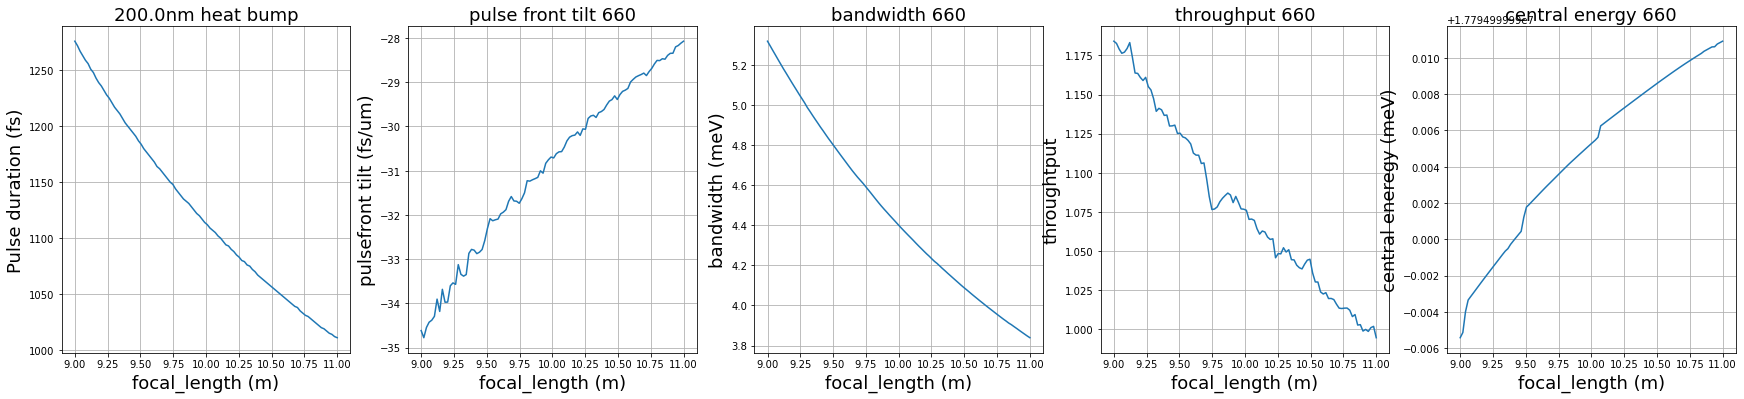

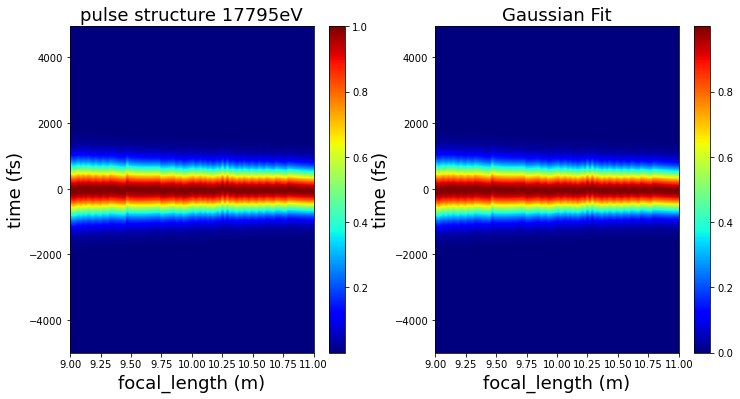

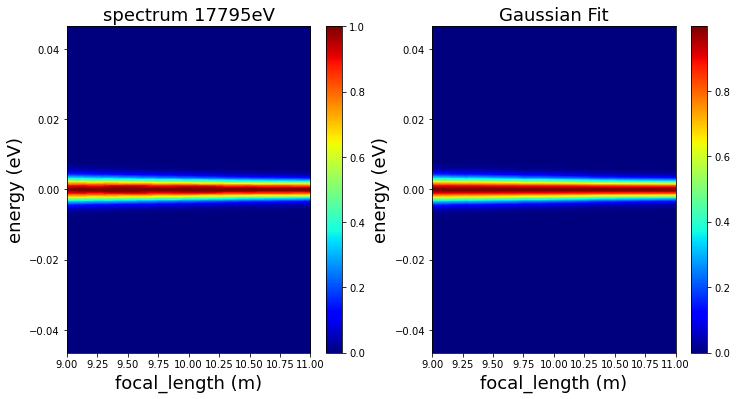

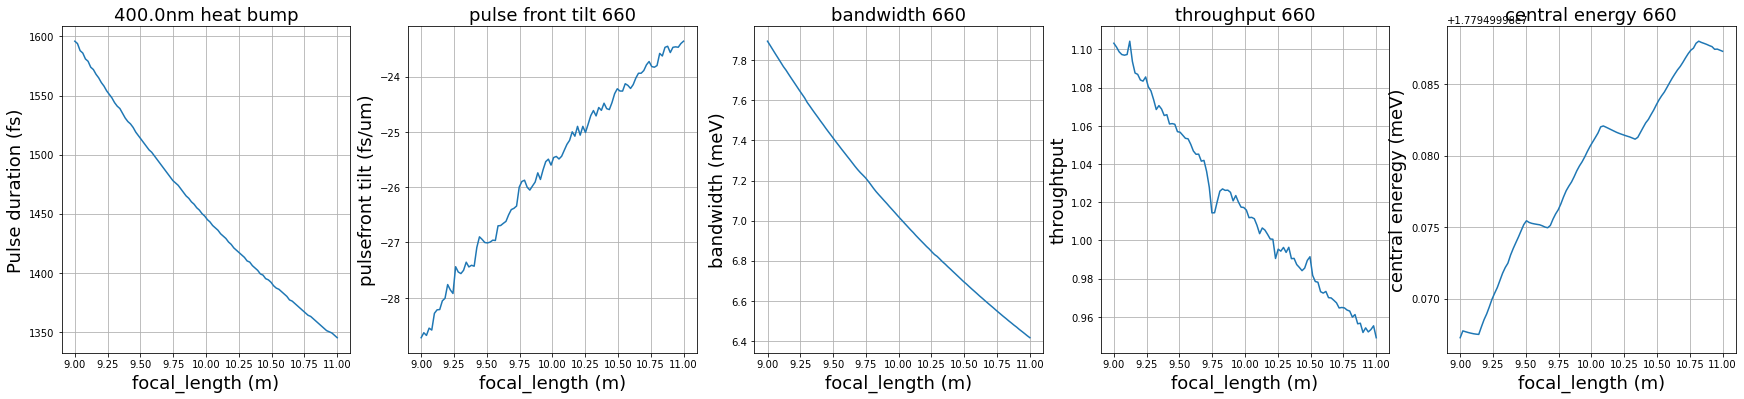

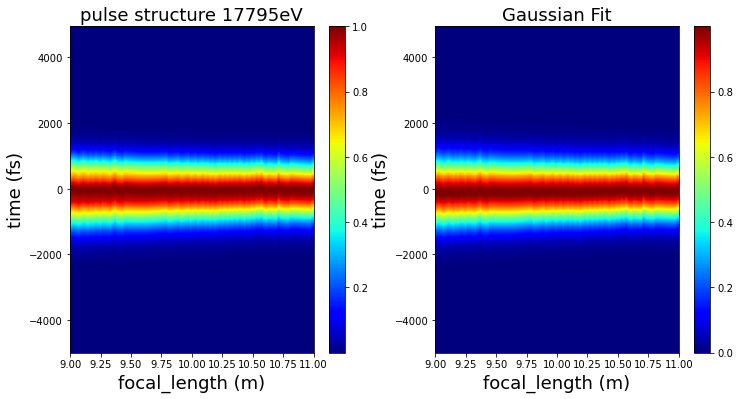

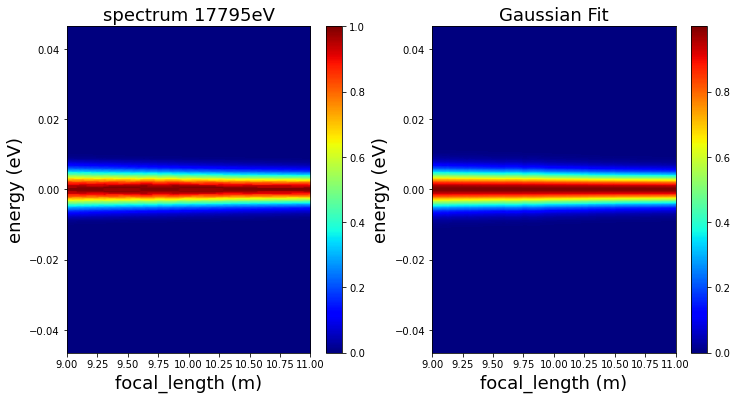

In [19]:
fig_path = "C:/Users/nanw0/GoogleDrive/SLAC/SLAC-Diling/9. 20 Summer/Hasan Mono Analysis/Matt's_Plots/"
hkl = devices[2].hkl
hkl = int(hkl[0]*100+hkl[1]*10+hkl[2])
fname = 'heat_bump_compensation_{}_{}keV'.format(
    hkl, round(beam_params['photonEnergy']/1000.,4))

for case in [0,1]:
    grpname = 'case{}'.format(case)
    with h5py.File(fig_path+fname+'.h5', 'r') as f:
        slope_slope = f[grpname+'/slope_slope'][0]
        focal_length_list = f[grpname+'/focal_length_list'][:]
        duration = f[grpname+'/duration'][:]
        pulse_list = f[grpname+'/pulse_list'][:]
        pulse_fit_list = f[grpname+'/pulse_fit_list'][:]
        tilt = f[grpname+'/tilt'][:]
        bw = f[grpname+'/bandwidth'][:]
        throughput = f[grpname+'/throughput'][:]
        cent_E = f[grpname+'/central_energy'][:]
        spectrum_list = f[grpname+'/spectrum_list'][:]
        spectrum_fit_list = f[grpname+'/spectrum_fit_list'][:]

    # plots
    xx = focal_length_list
    xlabel = 'focal_length (m)'

    # pulse duration
    plt.figure(figsize=(30,6))
    plt.subplot(1,5,1)
    plt.plot(xx, np.abs(duration))
    plt.xlabel(xlabel,fontsize=(18))
    plt.ylabel('Pulse duration (fs)',fontsize=(18))

    plt.grid()
    plt.title('{}nm heat bump'.format(round(1e3*slope_slope,2)),fontsize=(18))

    # pulsefront tilt
    plt.subplot(1,5,2)
    plt.plot(xx, tilt)
    plt.xlabel(xlabel,fontsize=(18))
    plt.ylabel('pulsefront tilt (fs/um)',fontsize=(18))

    plt.grid()
    plt.title('pulse front tilt {}'.format(hkl),fontsize=(18))
    # bandwidth
    plt.subplot(1,5,3)
    plt.plot(xx, 1e3*bw)
    plt.xlabel(xlabel,fontsize=(18))
    plt.ylabel('bandwidth (meV)',fontsize=(18))

    plt.grid()
    plt.title('bandwidth {}'.format(hkl),fontsize=(18))

    # throughput
    plt.subplot(1,5,4)
    plt.plot(xx, throughput)
    plt.xlabel(xlabel,fontsize=(18))
    plt.ylabel('throughtput',fontsize=(18))

    plt.grid()
    plt.title('throughput {}'.format(hkl),fontsize=(18))

    # central energy
    plt.subplot(1,5,5)
    plt.plot(xx, 1e3*cent_E)
    plt.xlabel(xlabel,fontsize=(18))
    plt.ylabel('central eneregy (meV)',fontsize=(18))

    plt.grid()
    plt.title('central energy {}'.format(hkl),fontsize=(18))

    plt.savefig(fig_path+fname[:-9]+'{}slope_'.format(slope_slope)+fname[-9:]+'.png')

    # pulse structure scan
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(pulse_list.T, cmap='jet',
              extent = [focal_length_list.min(), focal_length_list.max(), t_axis.min(), t_axis.max()])
    plt.colorbar()
    plt.xlabel(xlabel,fontsize=18)
    plt.ylabel('time (fs)',fontsize=18)
    plt.axis('tight')
    plt.title('pulse structure {}eV'.format(E0),fontsize=18)

    plt.subplot(1,2,2)
    plt.imshow(pulse_fit_list.T, cmap='jet',
              extent = [focal_length_list.min(), focal_length_list.max(), t_axis.min(), t_axis.max()])
    plt.colorbar()
    plt.xlabel(xlabel,fontsize=18)
    plt.ylabel('time (fs)',fontsize=18)
    plt.axis('tight')
    plt.title('Gaussian Fit',fontsize=18)
    plt.savefig(fig_path+'pulse_structure_compensation_scan_{}_{}slope_{}keV.png'.format(
        hkl, slope_slope, round(beam_params['photonEnergy']/1000.,4)))

    # spectrum scan
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(spectrum_list.T, cmap='jet',
              extent = [focal_length_list.min(), focal_length_list.max(), energy_axis.min(), energy_axis.max()])
    plt.colorbar()
    plt.xlabel(xlabel,fontsize=18)
    plt.ylabel('energy (eV)',fontsize=18)
    plt.axis('tight')
    plt.title('spectrum {}eV'.format(E0),fontsize=18)

    plt.subplot(1,2,2)
    plt.imshow(spectrum_fit_list.T, cmap='jet',
              extent = [focal_length_list.min(), focal_length_list.max(), energy_axis.min(), energy_axis.max()])
    plt.colorbar()
    plt.xlabel(xlabel,fontsize=18)
    plt.ylabel('energy (eV)',fontsize=18)
    plt.axis('tight')
    plt.title('Gaussian Fit',fontsize=18)
    plt.savefig(fig_path+'spectrum_compensation_scan_{}_{}slope_{}keV.png'.format(
        hkl, slope_slope, round(beam_params['photonEnergy']/1000.,4)))


In [10]:
print('time per slice {}ms'.format(1000*(tfin-tstart)/4/2/NN/pulse.N))
print('total time {}s'.format(tfin-tstart))

time per slice 34.146093228565796ms
total time 6118.9799065589905s


In [11]:
print(fig_path+fname)

C:/Users/nanw0/GoogleDrive/SLAC/SLAC-Diling/9. 20 Summer/Hasan Mono Analysis/Matt's_Plots/heat_bump_compensation_660_17.795keV


In [12]:
for i in range(2):
    winsound.Beep(1000,1000)
    time.sleep(1.1)

'17.795keV'